# Food Mart Sales Profit Prediction
- Authors: Gian Luky S., Daud M. Azhari, Rahma Nur A.
- Date: September 2023



In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import datetime

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_classif
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error

import shap 

## 1. Data
1. drop unit sales and SRP: it's a trivial thing, basically tell us how much we'd get, yh gitulah
1. drop almost perfect collinearity: avg cars.1, gross weight, salad_bar (eqto prep food)
1. no NA
1. manual encoder: 
1. object will be encoded using ordinal encoder (eh, satunya apa yg hmm)
1. From the correlation, do we need trf? sama aja deng.
1. lanjut modelling sih, no outlier management lalala
1. dah bagus ygy.


In [92]:
# Weit, just do nothing, okeu. renaming
df1 = pd.read_csv("/kaggle/input/medias-cost-prediction-in-foodmart/media prediction and its cost.csv")
display(df1.select_dtypes("object").describe())
df1.drop(columns="avg_cars_at home(approx).1", inplace=True)

df1.columns = [j.split("(")[0].replace(". ", "_").replace(" ", "_") for j in df1.columns]

display(df1[["store_sales", "store_cost", "SRP", "unit_sales"]].corr())

df1["profit"] = df1["store_sales"] - df1["store_cost"]


df1 = df1.drop(["store_sales", "store_cost", "unit_sales"], axis = 1)
df1.head()

df1.columns

,food_category,food_department,food_family,promotion_name,sales_country,marital_status,gender,education,member_card,occupation,houseowner,avg. yearly_income,brand_name,store_type,store_city,store_state,media_type
count,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428,60428
unique,45,22,3,49,3,2,2,5,4,5,2,8,111,5,19,10,13
top,Vegetables,Produce,Food,Weekend Markdown,USA,S,F,Partial High School,Bronze,Professional,Y,$30K - $50K,Hermanos,Supermarket,Tacoma,WA,"Daily Paper, Radio"
freq,7440,8521,43284,2330,38892,30355,30942,18201,33807,19915,36510,19514,1839,26192,5704,19370,6820


,store_sales,store_cost,SRP,unit_sales
store_sales,1.000000,0.954685,0.833478,0.503482
store_cost,0.954685,1.000000,0.795880,0.480087
SRP,0.833478,0.795880,1.000000,-0.002358
unit_sales,0.503482,0.480087,-0.002358,1.000000


Index(['food_category', 'food_department', 'food_family', 'promotion_name',
       'sales_country', 'marital_status', 'gender', 'total_children',
       'education', 'member_card', 'occupation', 'houseowner',
       'avg_cars_at_home', 'avg_yearly_income', 'num_children_at_home',
       'brand_name', 'SRP', 'gross_weight', 'net_weight', 'recyclable_package',
       'low_fat', 'units_per_case', 'store_type', 'store_city', 'store_state',
       'store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'coffee_bar',
       'video_store', 'salad_bar', 'prepared_food', 'florist', 'media_type',
       'cost', 'profit'],
      dtype='object')

In [38]:
# df1.describe()
df1.head()
# df1[["food_category", "food_department", "food_family"]].value_counts()
# df1.shape

,food_category,food_department,food_family,promotion_name,sales_country,marital_status,gender,total_children,education,member_card,...,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost,profit
0,Breakfast Foods,Frozen Foods,Food,Bag Stuffers,USA,M,F,1.0,Partial High School,Normal,...,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",126.62,4.6368
1,Breakfast Foods,Frozen Foods,Food,Cash Register Lottery,USA,M,M,0.0,Bachelors Degree,Silver,...,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",59.86,2.9256
2,Breakfast Foods,Frozen Foods,Food,High Roller Savings,USA,S,F,4.0,Partial High School,Normal,...,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",84.16,2.3184
3,Breakfast Foods,Frozen Foods,Food,Cash Register Lottery,USA,M,F,2.0,High School Degree,Bronze,...,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,In-Store Coupon,95.78,2.5024
4,Breakfast Foods,Frozen Foods,Food,Double Down Sale,USA,M,M,0.0,Partial High School,Bronze,...,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,Radio,50.79,2.6520


In [39]:
# df1.iloc[:,3].nunique(), df1.iloc[:,4].nunique(), df1.iloc[:,5].nunique()

In [40]:
# how promotion increase the sale?
df1.select_dtypes(exclude="object").head()

,total_children,avg_cars_at_home,num_children_at_home,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,profit
0,1.0,1.0,1.0,1.84,19.70,17.70,1.0,0.0,17.0,27694.0,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,126.62,4.6368
1,0.0,4.0,0.0,1.84,19.70,17.70,1.0,0.0,17.0,27694.0,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,59.86,2.9256
2,4.0,1.0,0.0,1.84,19.70,17.70,1.0,0.0,17.0,27694.0,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,84.16,2.3184
3,2.0,2.0,2.0,1.84,19.70,17.70,1.0,0.0,17.0,27694.0,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,95.78,2.5024
4,0.0,2.0,0.0,1.36,7.12,5.11,0.0,1.0,29.0,27694.0,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,50.79,2.6520


In [41]:
# obj = df2.select_dtypes("object").columns
# [df2[x].value_counts() for x in obj]

## 2. Preprocessing & EDA

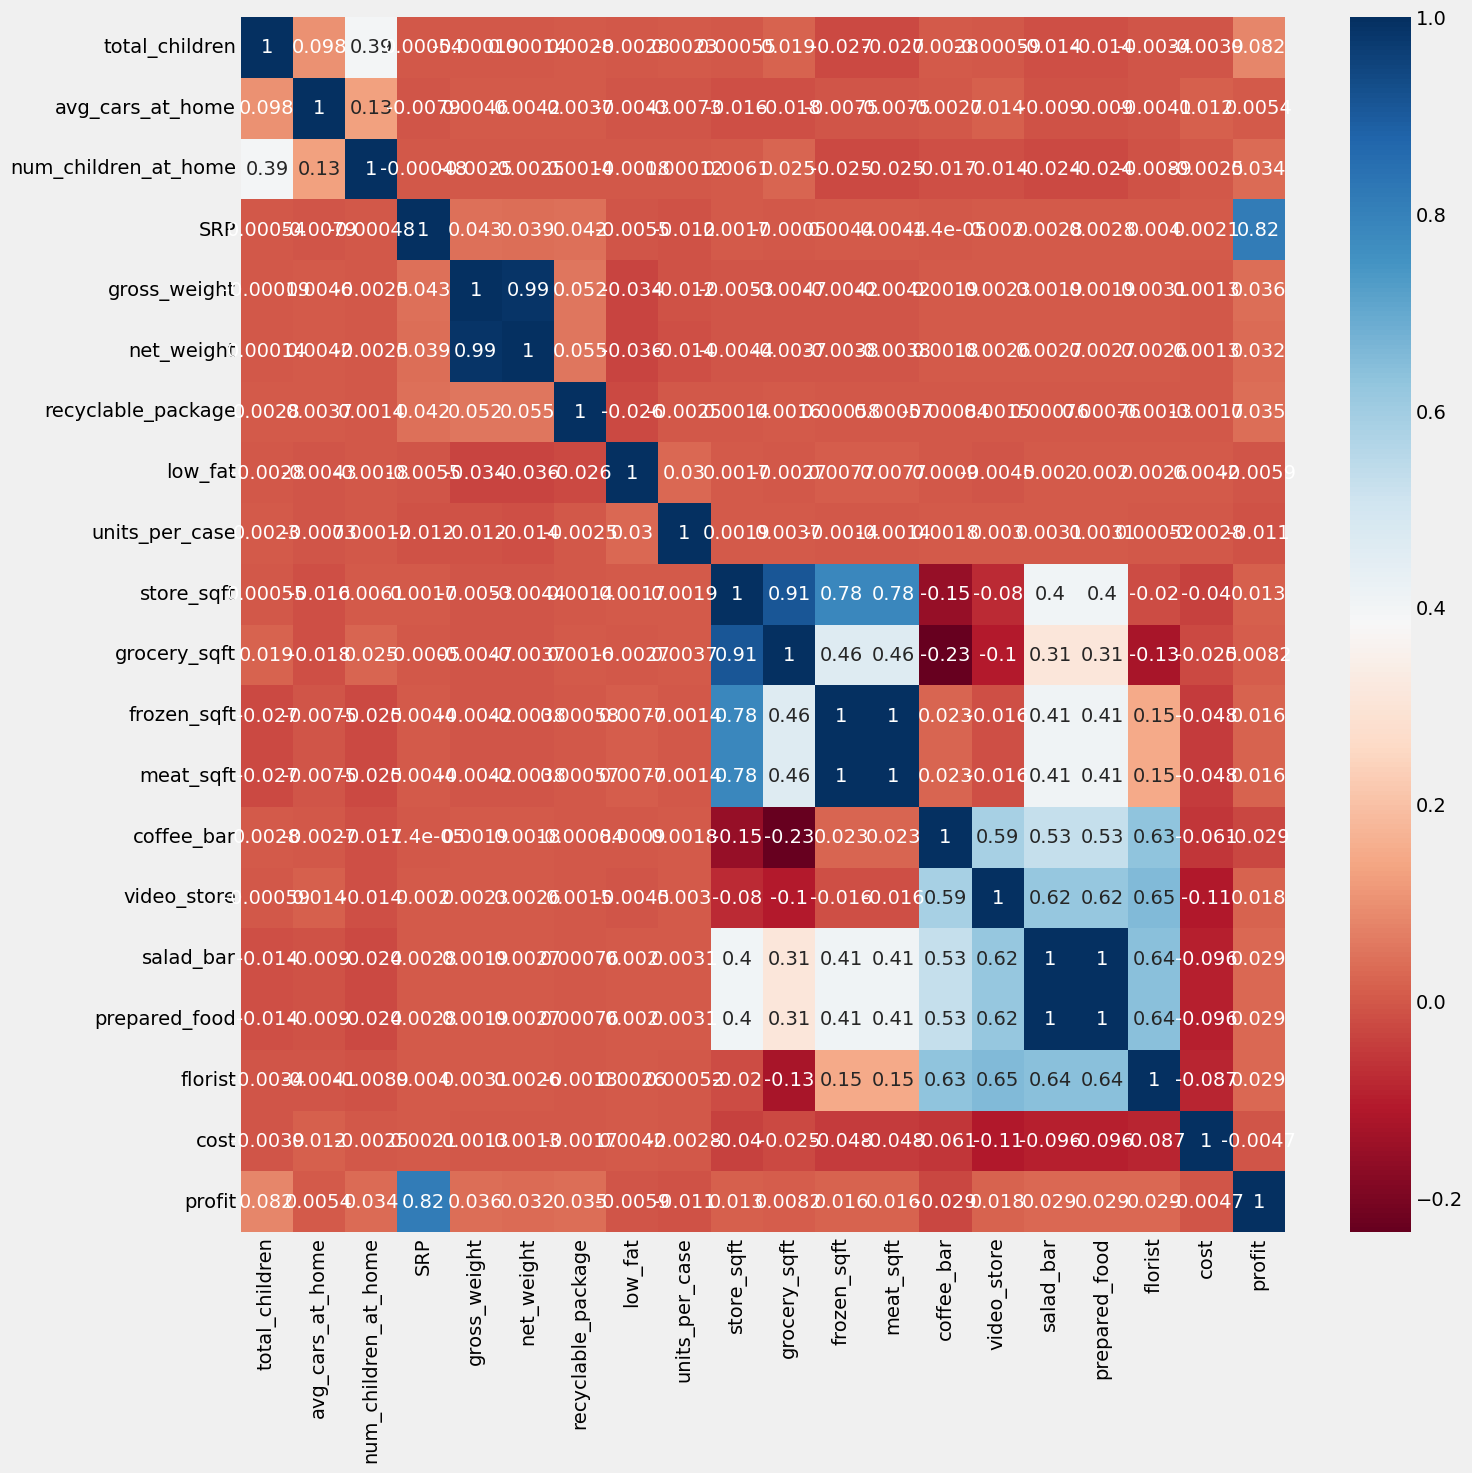

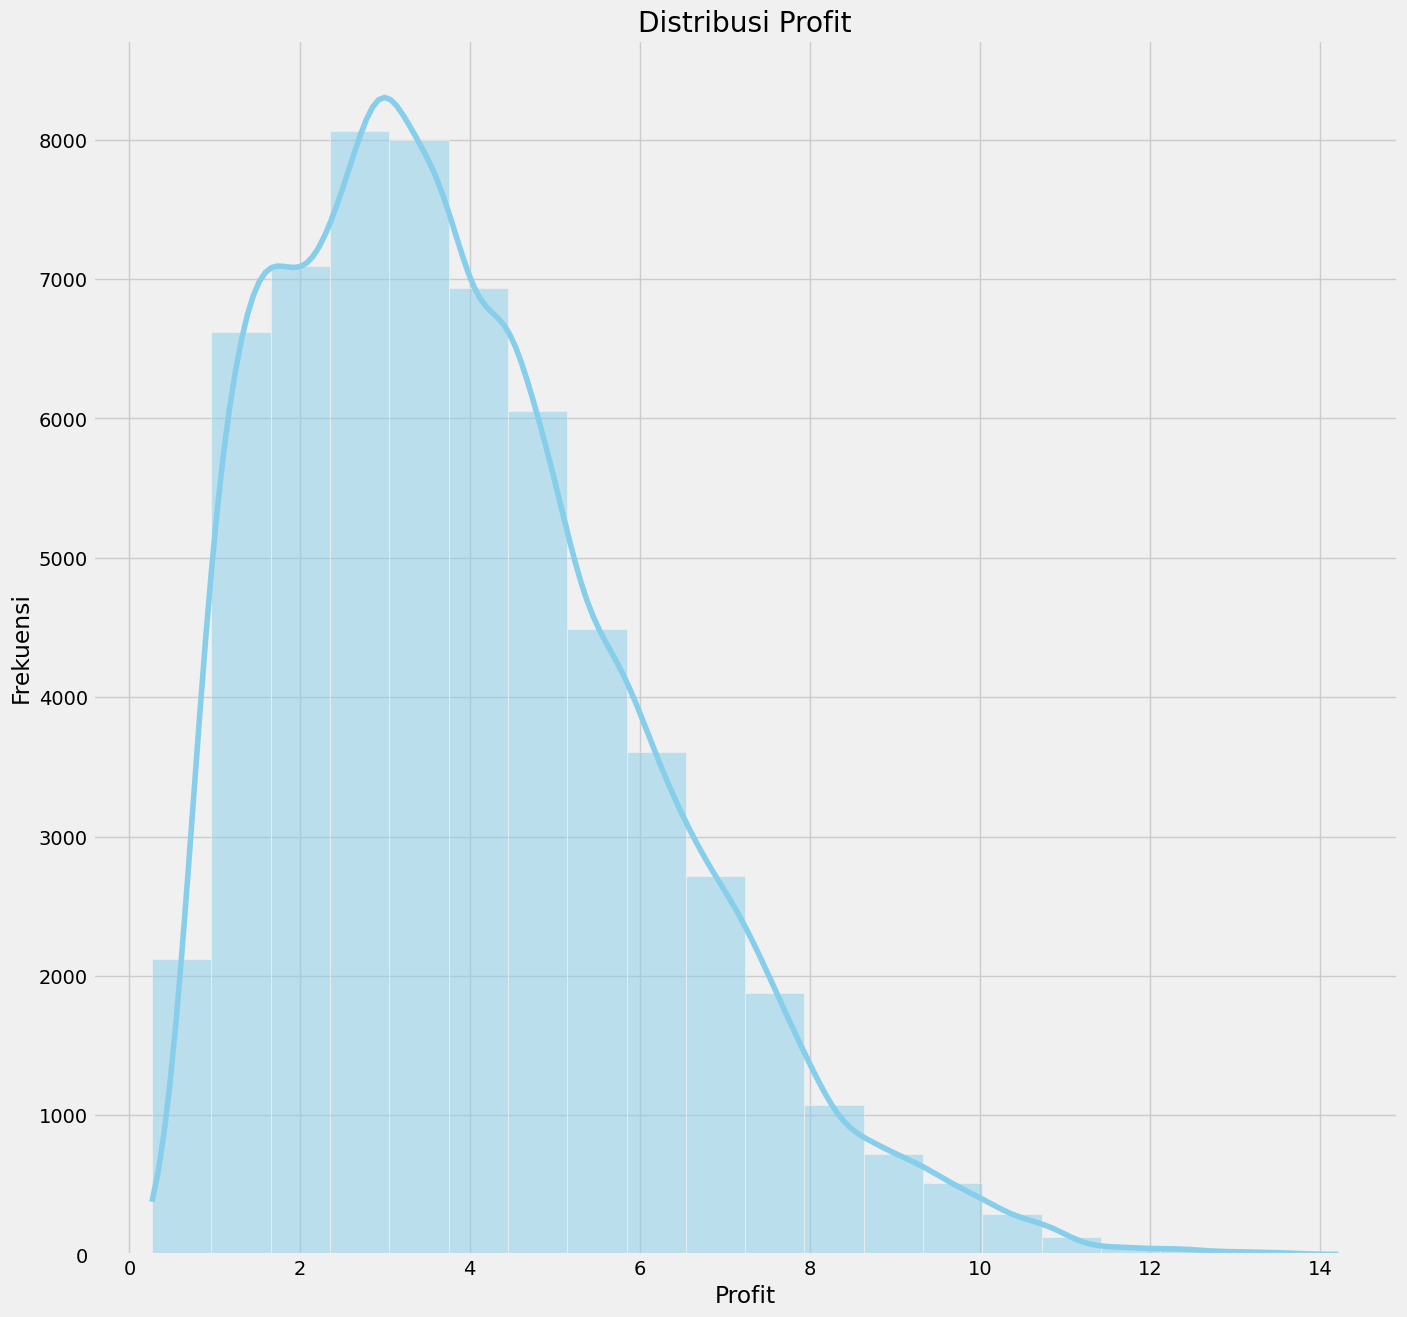

In [42]:
plt.figure(figsize=(15,15))
sns.heatmap(df1.select_dtypes(exclude="object").corr(), cmap="RdBu", annot=True)
plt.savefig("/kaggle/working/heatmap1")

plt.figure(figsize=(15,15))
# sns.histplot(df1["profit"], bins=20)
sns.histplot(data=df1, x="profit", bins=20, kde=True, color="skyblue") 
plt.title("Distribusi Profit")  # Judul plot
plt.xlabel("Profit")  # Label sumbu x
plt.ylabel("Frekuensi") 
plt.savefig("/kaggle/working/profit")

23

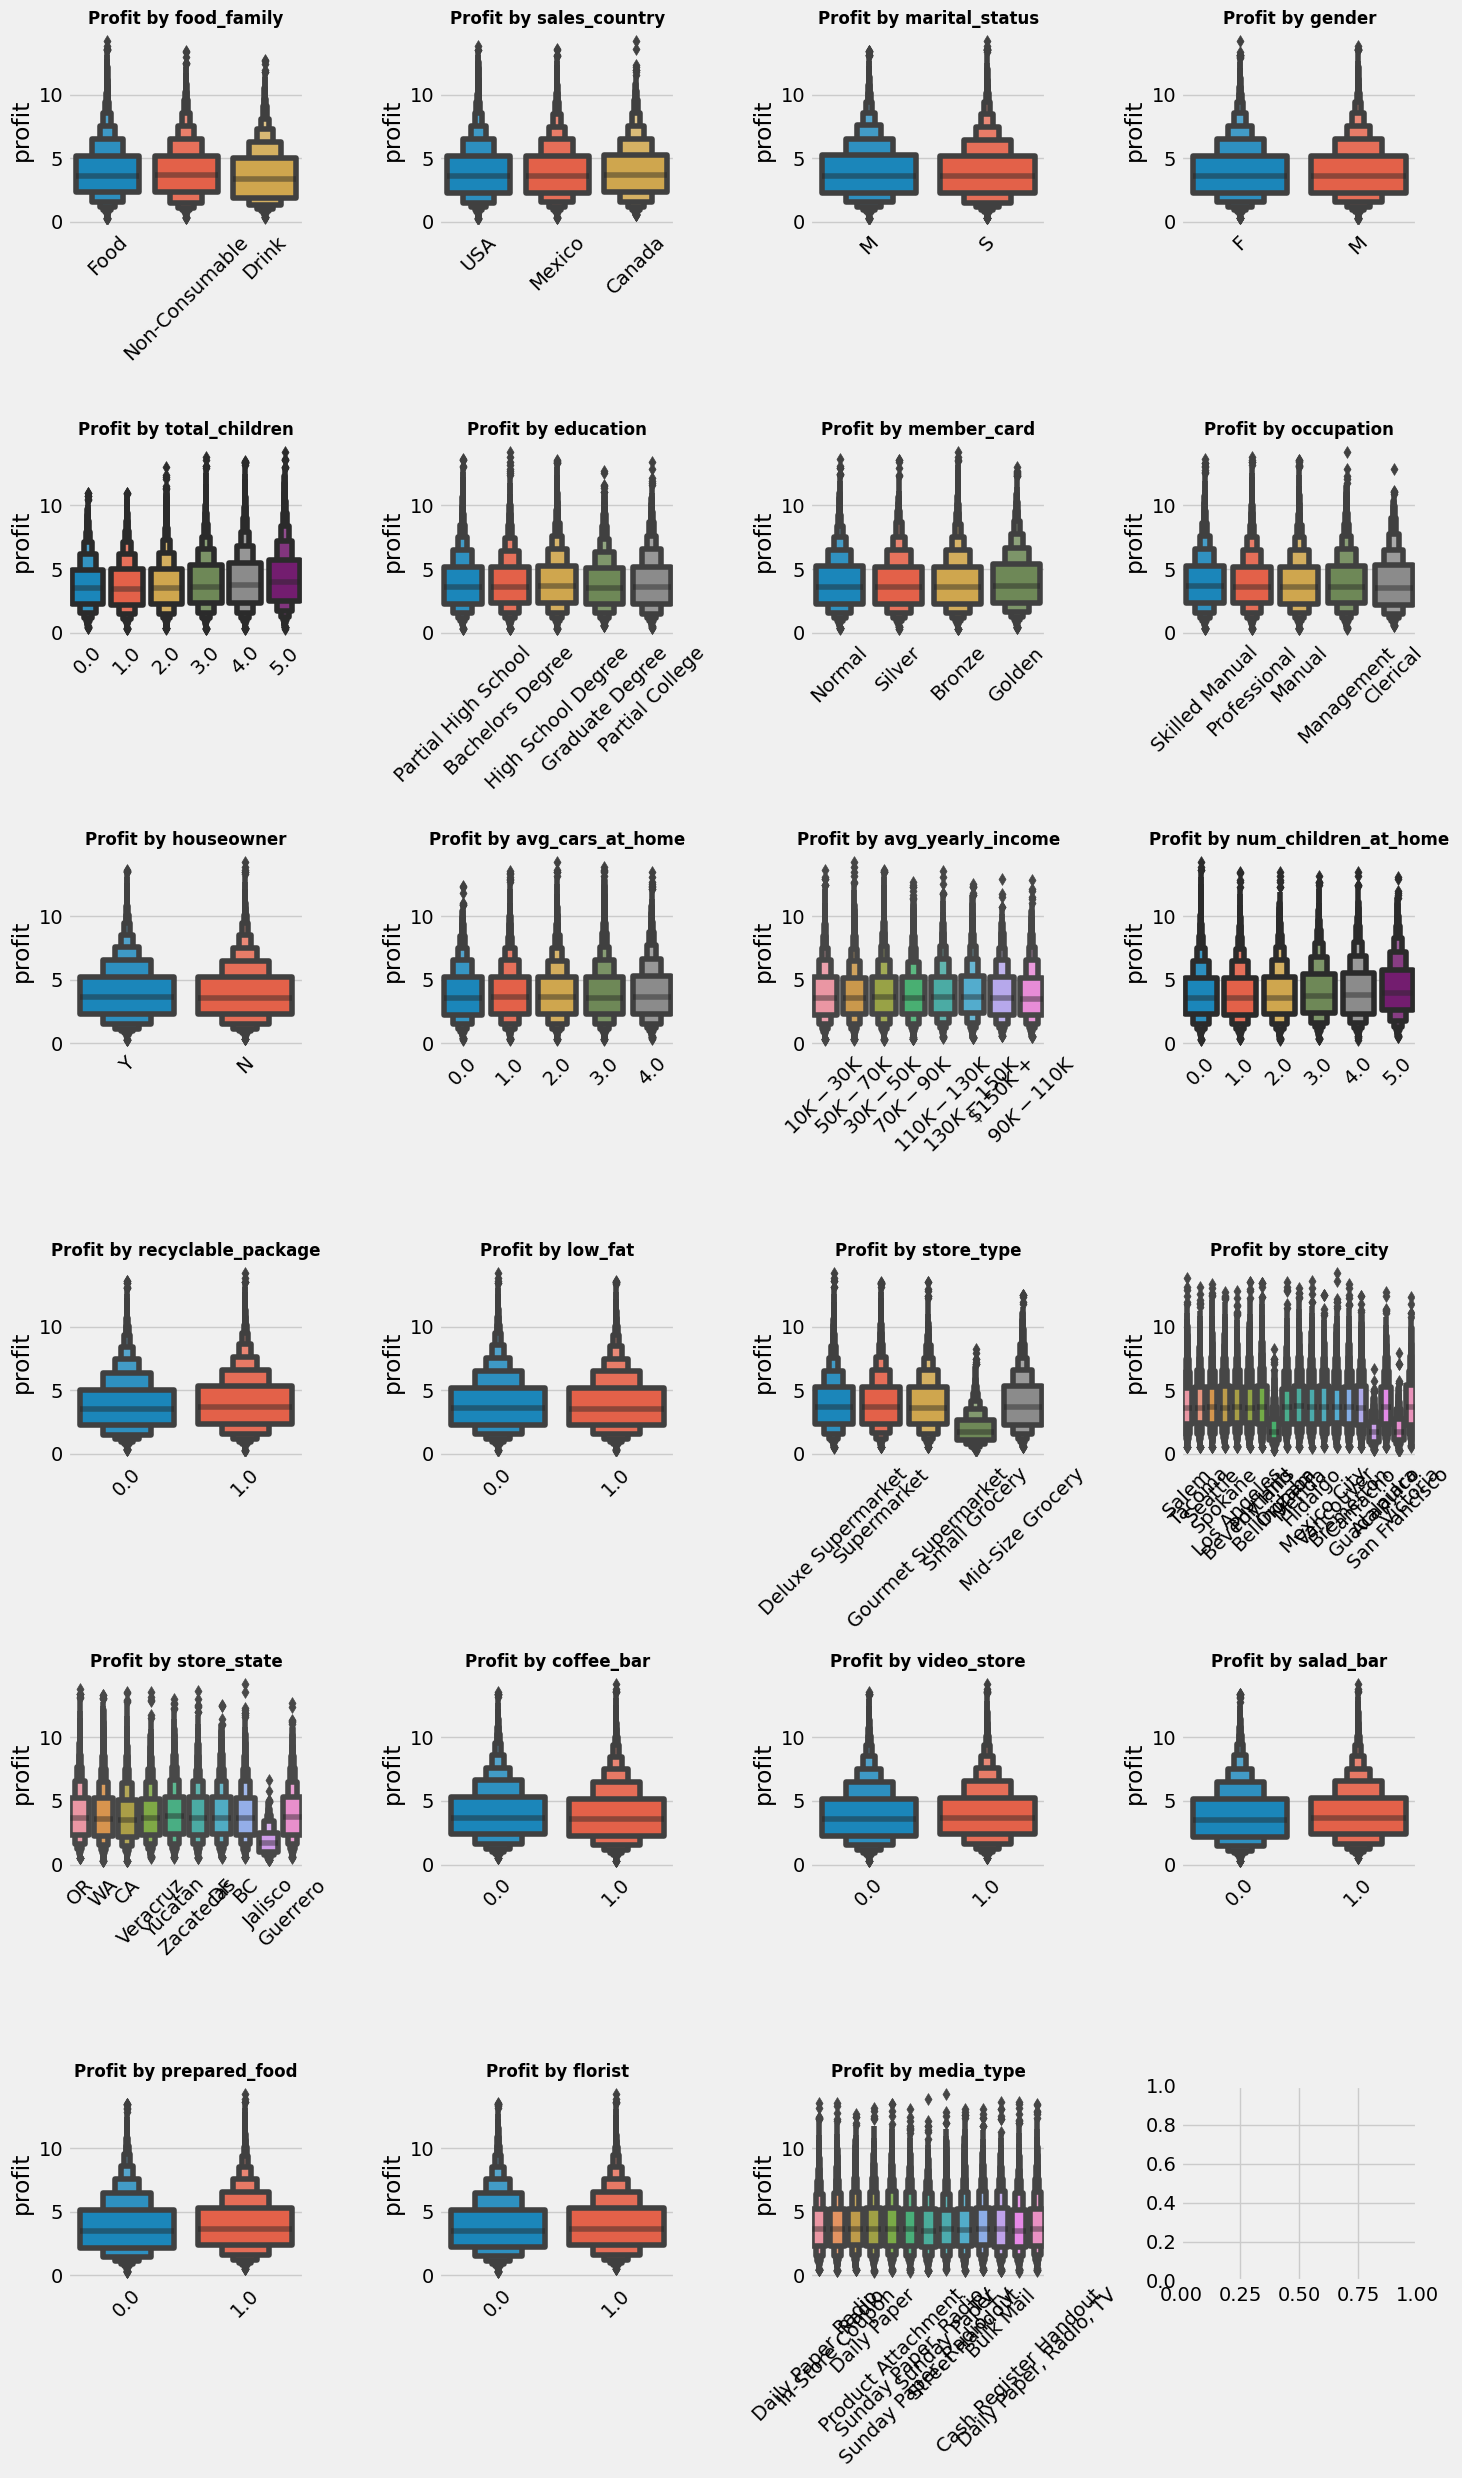

In [43]:
var1 = set(df1.select_dtypes("object").columns.tolist() + df1.loc[:, df1.nunique() < 10].columns.tolist())
var1 = df1.loc[:, df1.nunique() < 20].columns.tolist()

display(len(var1))

fig, axes = plt.subplots(6, 4, figsize=(15, 25), sharey=False)
axes = axes.ravel()

for i, var in enumerate(var1):
    sns.boxenplot(data=df1, x=var, y='profit', ax=axes[i])
    axes[i].set_title(f'Profit by {var}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('profit')
    axes[i].tick_params(axis='x', rotation=45)
    pass

plt.tight_layout()
plt.savefig("/kaggle/working/dist_fitur")

<Axes: >

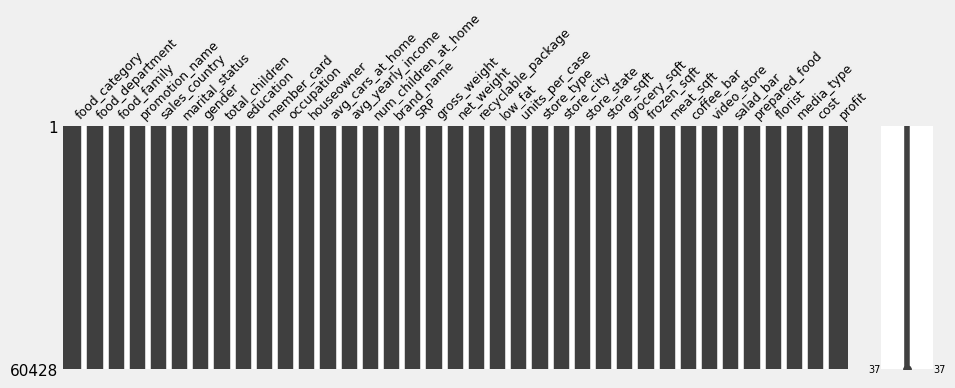

In [44]:
# ALL right and SOUND
msno.matrix(df1, figsize=(10,3), fontsize=9)
# df1.isna().sum(0)/df1.shape[0]*100

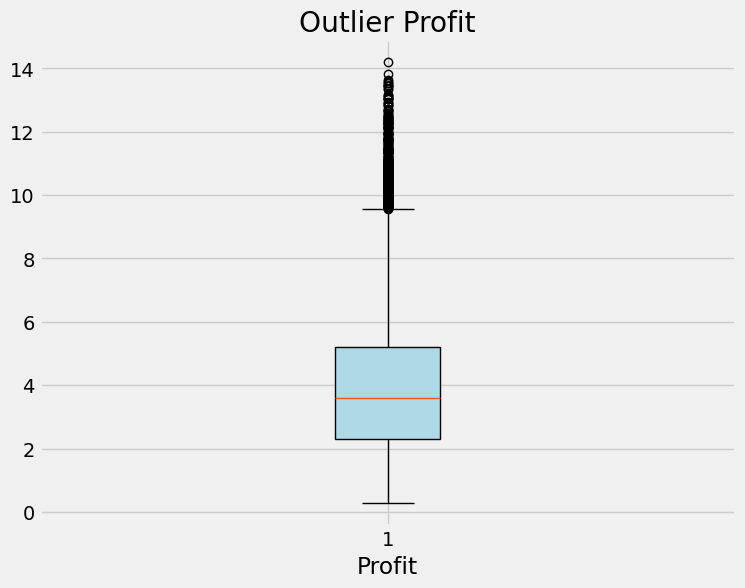

In [45]:
plt.figure(figsize=(8, 6))  
plt.boxplot(df1.profit, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Outlier Profit")  
plt.xlabel("Profit")

plt.savefig("/kaggle/working/boxp_profit")
plt.show() 

#### Store Location

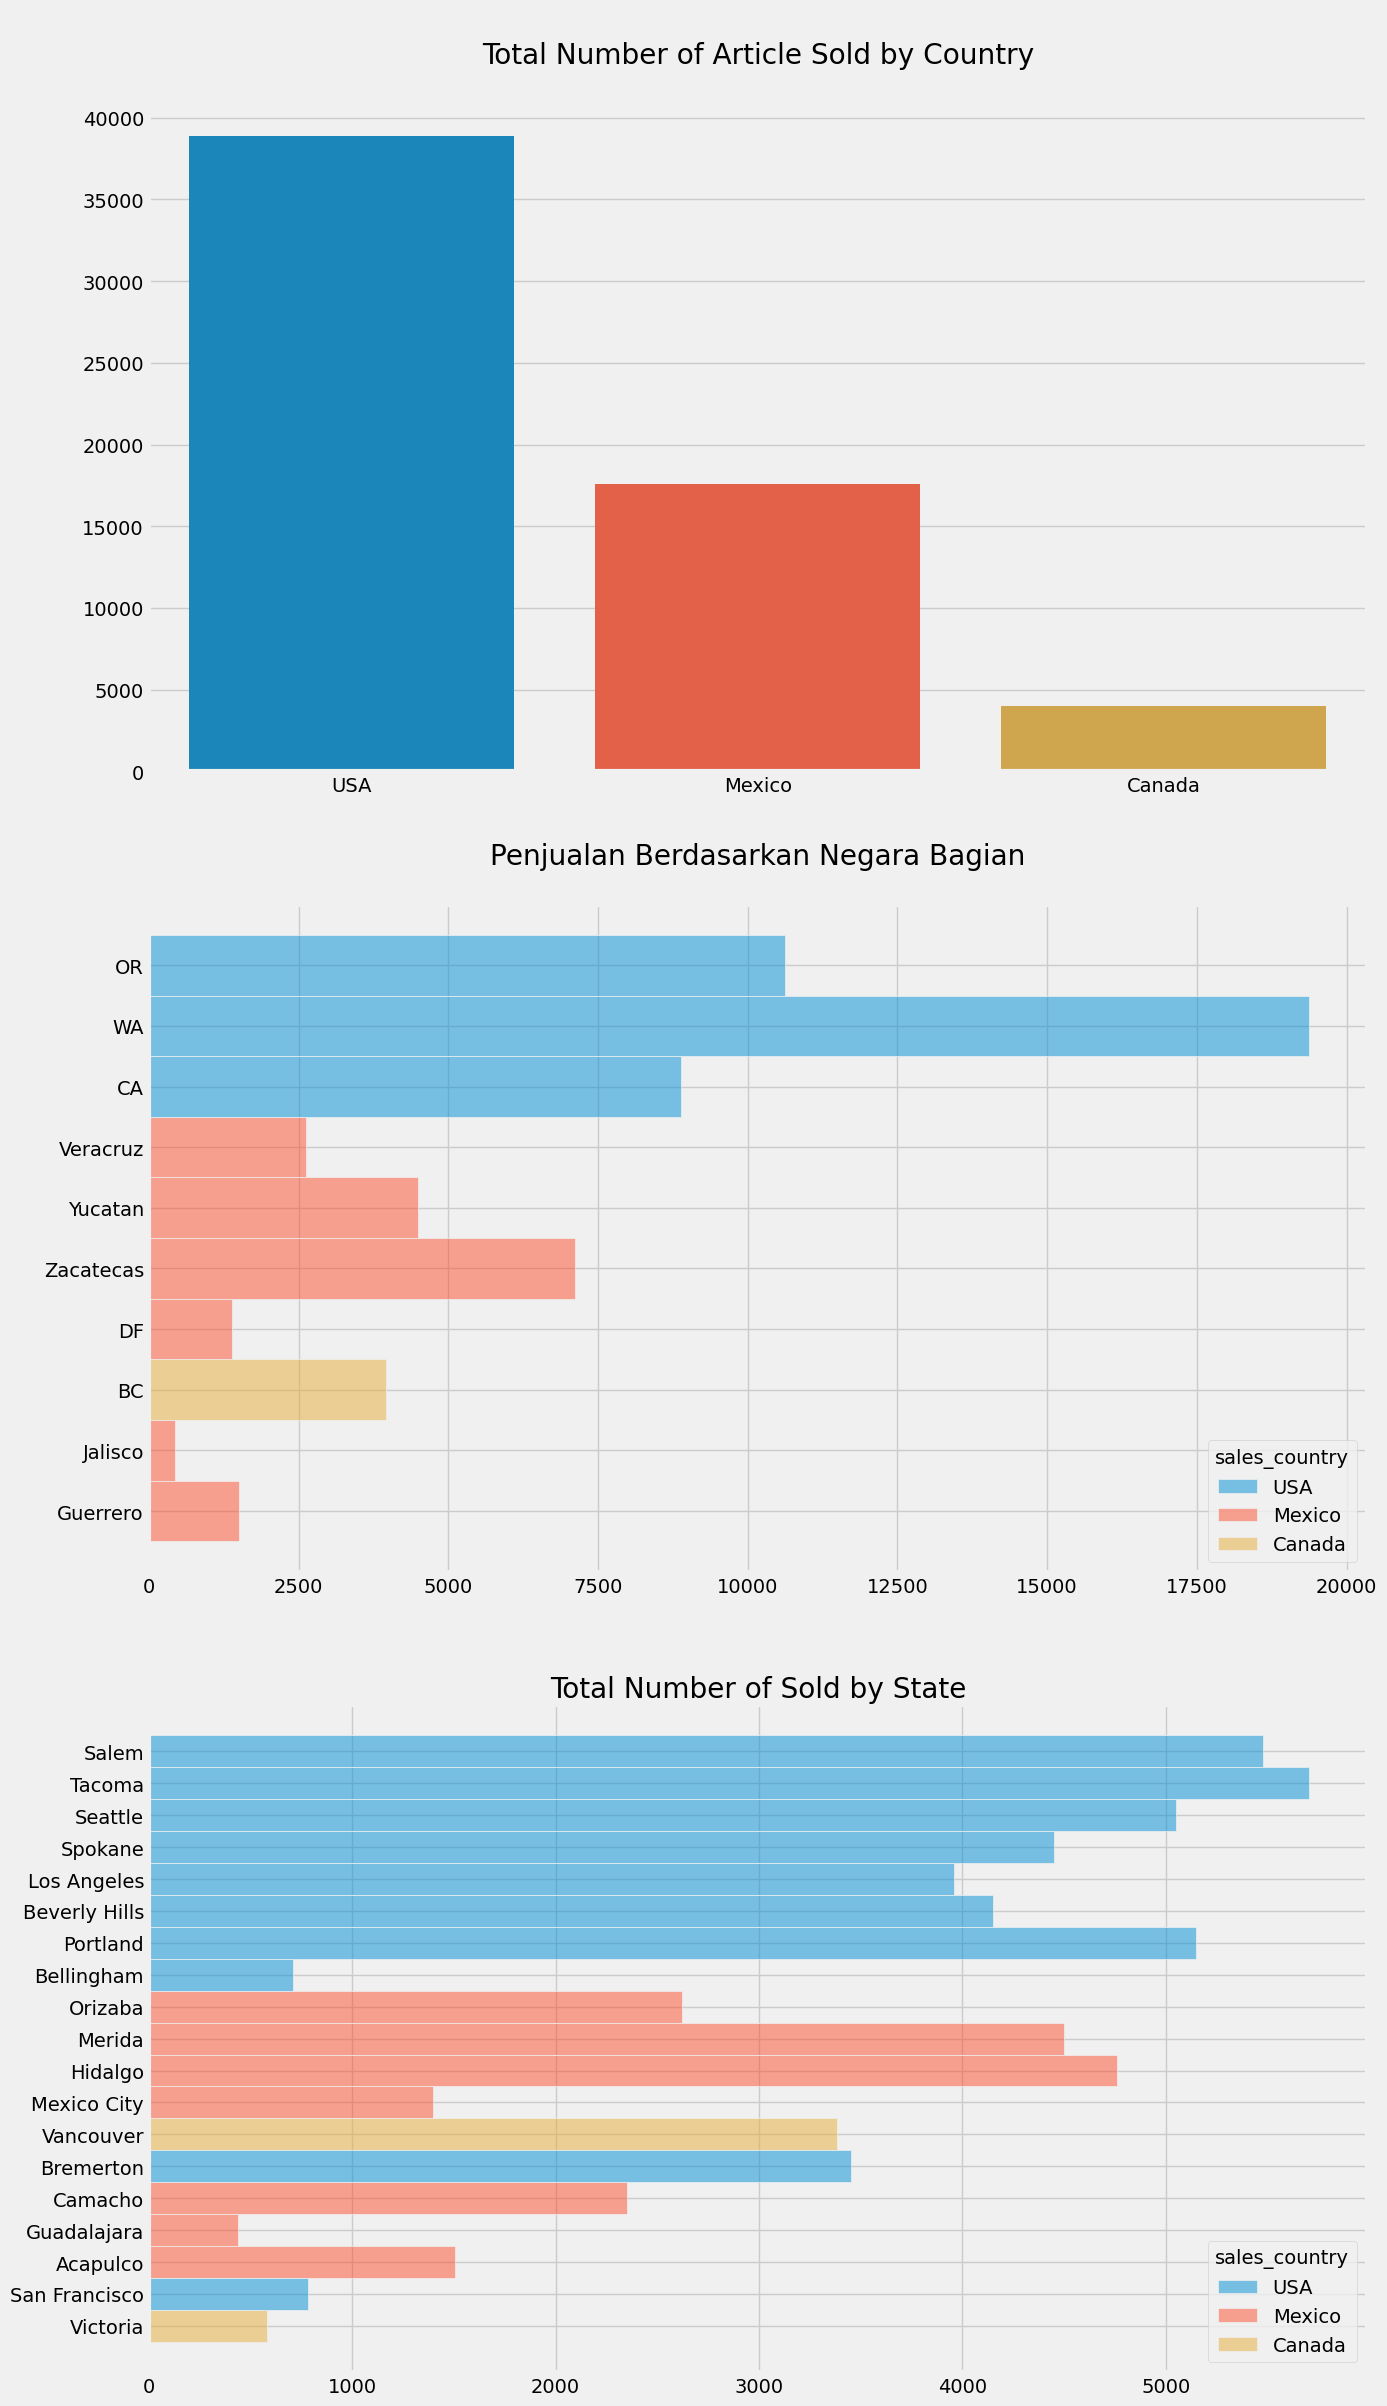

In [46]:
plt.style.use('fivethirtyeight')
_, ax = plt.subplots(3,1, figsize=(14,28))

sns.countplot(ax=ax[0], data=df1, x='sales_country')
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title('\nTotal Number of Article Sold by Country\n')

sns.histplot(ax=ax[1], data=df1, y='store_state', hue='sales_country')
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_title('\nPenjualan Berdasarkan Negara Bagian\n')

sns.histplot(ax=ax[2], data=df1, y='store_city', hue='sales_country')
ax[2].set_ylabel(None)
ax[2].set_xlabel(None)
ax[2].set_title('\nTotal Number of Sold by State')

plt.savefig("/kaggle/working/State")
plt.show()

#### Customer Demographic

In [47]:
# _, ax = plt.subplots(3,1, figsize=(14,28)) 

# sns.countplot(ax=ax[0], data=df1, y='gender')
# ax[0].set_ylabel(None)
# ax[0].set_xlabel(None)
# ax[0].set_yticks([1,0], labels=['Male', 'Female'])
# ax[0].set_title('\nCustomer Gender')

# sns.countplot(ax=ax[1], data=df1, y='marital_status')
# ax[1].set_ylabel(None)
# ax[1].set_xlabel(None)
# ax[1].set_yticks([1,0], labels=['Married', 'Single'])
# ax[1].set_title('\nCustomers Marital Status')

# # sns.countplot(ax=ax[2], data=df1, y='houseowner')
# # ax[2].set_ylabel(None)
# # ax[2].set_xlabel(None)
# # ax[2].set_yticks([1,0], labels=['No', 'Yes'])
# # ax[2].set_title('\nCustomers Home Ownership')

# sns.countplot(ax=ax[2],data=df1, y='education')
# ax[2].set_ylabel(None)
# ax[2].set_xlabel(None)
# ax[2].set_yticks([0,1,2,3,4],
#              labels=['Partial High School', 'Bachelors','High School','Graduate', 'Bachelors*'])
# ax[2].set_title('\nCustomers Education Level')

# # sns.countplot(ax=ax[4], data=df1, y='occupation')
# # ax[4].set_ylabel(None)
# # ax[4].set_xlabel(None)
# # ax[4].set_yticks([0,1,2,3,4],
# #                 labels=['Skilled Manual', 'Professional', 'Manual', 'Management', 'Clerical'])
# # ax[4].set_title('\nCustomers Occupation Type')
# plt.tight_layout()
# plt.savefig("/kaggle/working/demog")
# plt.show()

In [48]:
# _, ax = plt.subplots(1, 2, figsize=(12, 5))

# sns.countplot(ax=ax[0], data=df1, x='gender', orient='h')
# ax[0].set_xlabel(None)
# ax[0].set_ylabel(None)
# ax[0].set_xticks([0, 1], labels=['Male', 'Female'])
# ax[0].set_title('Customer Gender')

# sns.countplot(ax=ax[1], data=df1, x='marital_status', orient='h')
# ax[1].set_xlabel(None)
# ax[1].set_ylabel(None)
# ax[1].set_xticks([0, 1], labels=['Married', 'Single'])
# ax[1].set_title('Customers Marital Status')

# plt.tight_layout()
# plt.savefig("/kaggle/working/demog2")
# plt.show()

In [49]:
# colunas = ['promotion_name', 'food_category', 'store_state', 'media_type']
# # colunas = ['promotion_name', 'media_type']

# color = ['#FBDB5A', '#E37052', '#C566FA', '#52ABE3', '#52FF5F', '#E4FB4B', '#E39C44', '#FA58A3', '#4444E3', '#42FFCE']

# plt.figure(figsize=(20, 40))

# for i, col in enumerate(colunas):
#     axes = plt.subplot(5, 2, i + 1)
    
#     top_10_values = df1[col].value_counts().nlargest(10).index
    
#     filtered_df = df1[df1[col].isin(top_10_values)]
    
#     sns.countplot(y=filtered_df[col], order=filtered_df[col].value_counts().index, palette=color)
#     plt.title("Top 10 " + col, fontsize=14)

# plt.tight_layout()
# plt.savefig("/kaggle/working/promosi")
# plt.show()


In [50]:
# colunas = ['food_category']

# color = ['#FBDB5A', '#E37052', '#C566FA', '#52ABE3', '#52FF5F', '#E4FB4B', '#E39C44', '#FA58A3', '#4444E3', '#42FFCE']

# plt.figure(figsize=(20, 40))

# for i, col in enumerate(colunas):
#     axes = plt.subplot(5, 2, i + 1)
    
#     top_10_values = df1[col].value_counts().nlargest(10).index
    
#     filtered_df = df1[df1[col].isin(top_10_values)]
    
#     sns.countplot(y=filtered_df[col], order=filtered_df[col].value_counts().index, palette=color)
#     plt.title("Top 10 " + col, fontsize=14)

# plt.tight_layout()
# plt.savefig("/kaggle/working/produk")
# plt.show()


#### Boughts Item

In [51]:
# _, ax = plt.subplots(4,1, figsize=(14,28))

# sns.countplot(ax=ax[0], data=df1, y='food_family')
# ax[0].set_ylabel(None)
# ax[0].set_xlabel(None)
# ax[0].set_yticks([0,1,2], labels=['Food', 'Other', 'Drink'])
# ax[0].set_title('\nItems purchased by Family')

# sns.histplot(ax=ax[1], data=df1, y='food_category', hue='food_family')
# ax[1].set_ylabel(None)
# ax[1].set_xlabel(None)
# ax[1].set_yticks([0,9,18,27,36,45], labels=['','','','','',''])
# ax[1].set_title('\nItems purchased by Category')

# sns.countplot(ax=ax[2], data=df1, y='low_fat')
# ax[2].set_ylabel(None)
# ax[2].set_xlabel(None)
# ax[2].set_yticks([0,1], labels=['Regular', 'Low Fat'])
# ax[2].set_title('\nIs the product Low Fat?')

# sns.countplot(ax=ax[3], data=df1, y='recyclable_package')
# ax[3].set_ylabel(None)
# ax[3].set_xlabel(None)
# ax[3].set_yticks([0,1], labels=['No', 'Recyclable'])
# ax[3].set_title('\nIs the product Recyclable?')

# plt.tight_layout()
# plt.savefig("/kaggle/working/produk")
# plt.show()

In [52]:
df1.food_family.value_counts()

food_family
Food              43284
Non-Consumable    11573
Drink              5571
Name: count, dtype: int64

In [53]:
## manual ordinal encoding var: edu, card, income, 
df1.select_dtypes("object").describe()

df2 = df1.copy()
df2.education.replace(['Partial High School', 'Bachelors Degree', 'High School Degree',
                       'Graduate Degree', 'Partial College'], [0,3,1,4,2], inplace=True)
df2.member_card.replace(['Normal', 'Silver', 'Bronze', 'Golden'], [0,2,1,3], inplace=True)
df2.avg_yearly_income.replace(['$10K - $30K', '$50K - $70K', '$30K - $50K', '$70K - $90K',
                               '$110K - $130K', '$130K - $150K', '$150K +', '$90K - $110K'],
                              [0,2,1,3,5,6,7,4], inplace=True)
df2.houseowner.replace(['Y', 'N'],[0,1], inplace=True)

# 1. drop unit sales and SRP: it's a trivial thing, basically tell us how much we'd get, yh gitulah
# 1. drop almost perfect collinearity: avg cars.1, gross weight, salad_bar (eqto prep food)
df2.drop(columns=["gross_weight", "salad_bar", 'meat_sqft', 'grocery_sqft', "SRP"], inplace=True)
df2 = df2[df2.profit<9.5].reset_index(drop=True)
df2.shape

(59540, 32)

In [54]:
# plt.figure(figsize=(15,15))
# sns.heatmap(df2.select_dtypes(exclude="object").corr(), cmap="RdBu", annot=True)

## Cleaning
Done above.

In [55]:
# display(df2.head(), df2.info())

In [56]:
df2.duplicated().sum()

0

In [57]:
# df1.head().transpose()

## 3. Modelling

In [58]:
from scipy.stats import pearsonr
from sklearn.inspection import permutation_importance
import shap

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as imbpipeline
import pandas as pd

# FOLD
rkf = KFold(n_splits=4, shuffle=True, random_state=0)


In [59]:
# Encoding, FE
X = df2.copy()

# Splitting Data
y = X.pop("profit")
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size = 0.3, random_state = 0)
display(Xtr, ytr)

,food_category,food_department,food_family,promotion_name,sales_country,marital_status,gender,total_children,education,member_card,...,store_city,store_state,store_sqft,frozen_sqft,coffee_bar,video_store,prepared_food,florist,media_type,cost
38342,Snack Foods,Snack Foods,Food,Three for One,Mexico,S,F,3.0,3,1,...,Orizaba,Veracruz,34791.0,5062.0,0.0,0.0,1.0,0.0,In-Store Coupon,125.48
5099,Vegetables,Produce,Food,Three for One,Mexico,M,F,4.0,0,0,...,Merida,Yucatan,30797.0,6393.0,1.0,1.0,1.0,1.0,"Sunday Paper, Radio",131.62
3606,Vegetables,Produce,Food,Price Destroyers,USA,S,F,3.0,0,1,...,Los Angeles,CA,23598.0,5633.0,0.0,0.0,0.0,1.0,TV,135.92
52422,Hygiene,Health and Hygiene,Non-Consumable,Free For All,USA,S,F,3.0,0,0,...,Bremerton,WA,39696.0,9184.0,0.0,0.0,1.0,0.0,Radio,140.90
12500,Decongestants,Health and Hygiene,Non-Consumable,You Save Days,USA,M,F,4.0,1,3,...,Los Angeles,CA,23598.0,5633.0,0.0,0.0,0.0,1.0,Bulk Mail,131.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45891,Frozen Entrees,Frozen Foods,Food,Pick Your Savings,Mexico,S,F,5.0,0,1,...,Merida,Yucatan,30797.0,6393.0,1.0,1.0,1.0,1.0,Radio,56.49
52416,Hygiene,Health and Hygiene,Non-Consumable,Shelf Clearing Days,USA,S,M,3.0,3,1,...,Bremerton,WA,39696.0,9184.0,0.0,0.0,1.0,0.0,Sunday Paper,106.10
42613,Breakfast Foods,Frozen Foods,Food,Dimes Off,Mexico,M,F,4.0,3,3,...,Hidalgo,Zacatecas,30584.0,5188.0,1.0,1.0,1.0,1.0,Radio,115.25
43567,Vegetables,Frozen Foods,Food,Mystery Sale,Mexico,M,M,4.0,1,1,...,Guadalajara,Jalisco,24597.0,5751.0,1.0,0.0,0.0,0.0,Street Handout,131.20


38342    1.8564
5099     6.8796
3606     5.7664
52422    8.4164
12500    0.8262
          ...  
45891    6.4032
52416    3.0720
42613    4.6170
43567    0.7865
2732     5.2948
Name: profit, Length: 41678, dtype: float64

In [60]:
X1 = Xtr.copy()
y1 = ytr.copy()
# X1.drop("SRP", axis = 1, inplace = True)

kat_kol = X1.select_dtypes("object").columns
num_kol = X1.select_dtypes(exclude="object").columns

# ordinal encoder
kat_trf1 = Pipeline(steps=[
    ("kat_en", OrdinalEncoder())
])

num_trf1 = Pipeline(steps=[("num_im", SimpleImputer(strategy="median"))])

# merge preprocessing
pre_1 = ColumnTransformer(transformers=[
    ('kat', kat_trf1, kat_kol),
    ('num', num_trf1, num_kol)
])

In [61]:
# # Define a list of regression models
# models = [
#     LinearRegression(),
#     ElasticNet(random_state=42),
#     RandomForestRegressor(random_state=42),
#     HistGradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# res1 = pd.DataFrame()

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("pre", pre_1),
#         ("clf", model)
#     ])
    
#     grid_search = GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, 
#                                scoring={"RMSE":'neg_root_mean_squared_error',
#                                         "MAE":'neg_mean_absolute_error',
#                                         "EV":'explained_variance',
#                                         "R2":'r2'},
#                                verbose=3,
#                                refit = "RMSE")
    
#     grid_search.fit(X1, y1)
    
#     # Save the model's performance metrics in a dictionary
    
#     pdf = pd.DataFrame(grid_search.cv_results_).filter(regex=("mean_test"))
#     pdf["Model"] = type(model).__name__ 
#     pdf.set_index("Model", inplace=True)
    
#     # concat pdDF to the results list
#     res1 = pd.concat([res1, pdf])
    


In [62]:
# res1

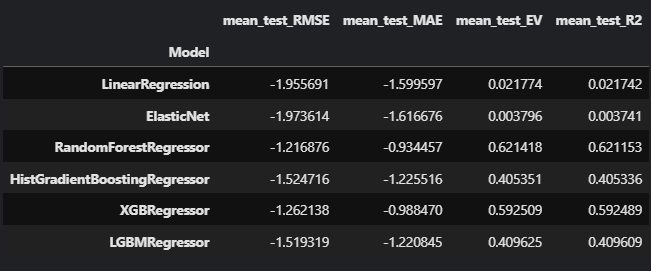

### HGB

In [63]:
# hgb1 = imbpipeline(steps=[
#     ("preprocess", pre_1),
#     ("clf", HistGradientBoostingRegressor(random_state=0))
# ])

# # param_grid = {
# #     'clf__learning_rate': [0.1, 0.2, 0.3, 0.4], 
# #     'clf__max_depth': [3, 5, 7, 10, None], 
# #     'clf__l2_regularization': [0.02, 0.01, 0.005]  
# # }

# param_grid = {
#     'clf__learning_rate': [0.4], 
#     'clf__max_depth': [None], 
#     'clf__l2_regularization': [0.01]
# }

# grid_hgb1 = GridSearchCV(estimator=hgb1, param_grid=param_grid, cv=rkf, 
#                         scoring={"RMSE":'neg_root_mean_squared_error',
#                                  "MAE":'neg_mean_absolute_error',
#                                  "EV":'explained_variance',
#                                  "R2":'r2'}, 
#                          verbose = 3, refit="RMSE")

# # Melakukan tuning hyperparameter
# grid_hgb1.fit(X1, y1)

# # Mendapatkan model terbaik
# print("Best Parameter", grid_hgb1.best_params_)

In [64]:
# display(grid_hgb1.best_estimator_.get_params()["clf"].get_params())
# display(pd.DataFrame(grid_hgb1.cv_results_).filter(regex='^mean',axis=1))

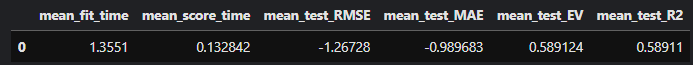

## LGBM

In [65]:
# lgb1 = imbpipeline(steps=[
#     ("preprocess", pre_1),
#     ("clf", LGBMRegressor(random_state=0))
# ])

# # param_grid = {
# #     'clf__learning_rate': [0.1, 0.05, 0.2],
# #     'clf__n_estimators': [100, 250, 500, 1000],
# #     'clf__max_depth': [3, 5, 7, 10, None],
# #     'clf__subsample': [0.6, 0.7, 0.8],
# #     'clf__reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5],
# #     'clf__reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5]
# # }

# param_grid = {
#     'clf__learning_rate': [0.2],
#     'clf__n_estimators': [500],
#     'clf__max_depth': [None],
#     'clf__subsample': [0.6],
#     'clf__reg_alpha': [0.3],
#     'clf__reg_lambda': [0.3]
# }

# grid_lgb1 = GridSearchCV(estimator=lgb1, param_grid=param_grid, cv=rkf, 
#                         scoring={"RMSE":'neg_root_mean_squared_error',
#                                  "MAE":'neg_mean_absolute_error',
#                                  "EV":'explained_variance',
#                                  "R2":'r2'}, 
#                          verbose = 3, refit="RMSE")

# # Melakukan tuning hyperparameter
# grid_lgb1.fit(X1, y1)

# # Mendapatkan model terbaik
# print("Best Parameter", grid_lgb1.best_params_)

In [66]:
# display(grid_lgb1.best_estimator_.get_params()["clf"].get_params())
# display(pd.DataFrame(grid_lgb1.cv_results_).filter(regex='^mean',axis=1))

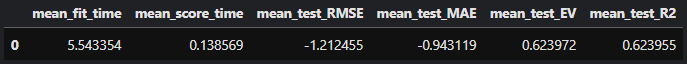

## XGB (Best Model)

In [67]:
xgb1 = imbpipeline(steps=[
    ("preprocess", pre_1),
    ("clf", XGBRegressor(random_state=0))
])

# param_grid = {
#     'clf__n_estimators': [100, 250, 500, 1000],
#     'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'clf__max_depth': [3, 5, 10]
# }

param_grid = {
    'clf__learning_rate': [0.1],
    'clf__n_estimators': [1000],
    'clf__max_depth': [5]
}

grid_xgb1 = GridSearchCV(estimator=xgb1, param_grid=param_grid, cv=rkf, 
                        scoring={"RMSE":'neg_root_mean_squared_error',
                                 "MAE":'neg_mean_absolute_error',
                                 "EV":'explained_variance',
                                 "R2":'r2'}, 
                         verbose = 3, refit="RMSE")

# Melakukan tuning hyperparameter
grid_xgb1.fit(X1, y1)

# Mendapatkan model terbaik
print("Best Parameter", grid_xgb1.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END clf__learning_rate=0.1, clf__max_depth=5, clf__n_estimators=1000; EV: (test=0.633) MAE: (test=-0.934) R2: (test=0.632) RMSE: (test=-1.205) total time=  24.9s
[CV 2/4] END clf__learning_rate=0.1, clf__max_depth=5, clf__n_estimators=1000; EV: (test=0.619) MAE: (test=-0.941) R2: (test=0.619) RMSE: (test=-1.211) total time=  24.9s
[CV 3/4] END clf__learning_rate=0.1, clf__max_depth=5, clf__n_estimators=1000; EV: (test=0.628) MAE: (test=-0.937) R2: (test=0.628) RMSE: (test=-1.206) total time=  23.7s
[CV 4/4] END clf__learning_rate=0.1, clf__max_depth=5, clf__n_estimators=1000; EV: (test=0.625) MAE: (test=-0.948) R2: (test=0.625) RMSE: (test=-1.214) total time=  25.1s
Best Parameter {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 1000}


In [68]:
display(grid_xgb1.best_estimator_.get_params()["clf"].get_params())
display(pd.DataFrame(grid_xgb1.cv_results_).filter(regex='^mean',axis=1))

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 1000,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 0,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

,mean_fit_time,mean_score_time,mean_test_RMSE,mean_test_MAE,mean_test_EV,mean_test_R2
0,24.48932,0.161332,-1.209056,-0.939996,0.626102,0.626077


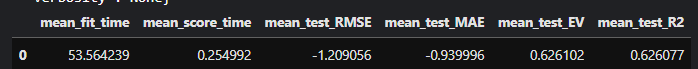

In [86]:
# find what?
xtr0 = Xtr.copy().reset_index(drop=True)

xtr1 = pd.DataFrame(grid_xgb1.best_estimator_.get_params()["preprocess"].transform(xtr0))
xtr1.columns = kat_kol.to_list() + num_kol.to_list()
xtr1.head().transpose()

xtr2 = xtr1.join(xtr0, rsuffix="B", lsuffix= "A")
xtr2 = xtr2[xtr2.columns.sort_values()]

display(xtr2.filter(regex=("food_cat")).value_counts().sort_index(ascending=False)[:10],
        xtr2.filter(regex=("brand")).value_counts().sort_index(ascending=True)[:10],
        xtr2.filter(regex=("food_fam")).value_counts().sort_index(ascending=True)[:10],
        xtr2.filter(regex=("store_type")).value_counts().sort_index(ascending=True)[:10],
        xtr2.filter(regex=("sales_country")).value_counts().sort_index(ascending=True)[:10],
        
        
       )



food_categoryA  food_categoryB      
44.0            Vegetables              5130
43.0            Starchy Foods            757
42.0            Specialty                829
41.0            Snack Foods             4782
40.0            Side Dishes              420
39.0            Seafood                  258
38.0            Pure Juice Beverages     530
37.0            Plastic Products         376
36.0            Pizza                    582
35.0            Paper Products          1067
Name: count, dtype: int64

brand_nameA  brand_nameB
0.0          ADJ             45
1.0          Akron           46
2.0          American       388
3.0          Amigo           57
4.0          Applause        56
5.0          Atomic         203
6.0          BBB Best       825
7.0          Best           114
8.0          Best Choice    899
9.0          Better         628
Name: count, dtype: int64

food_familyA  food_familyB  
0.0           Drink              3886
1.0           Food              29802
2.0           Non-Consumable     7990
Name: count, dtype: int64

store_typeA  store_typeB        
0.0          Deluxe Supermarket     15843
1.0          Gourmet Supermarket     4519
2.0          Mid-Size Grocery        1959
3.0          Small Grocery           1365
4.0          Supermarket            17992
Name: count, dtype: int64

sales_countryA  sales_countryB
0.0             Canada             2739
1.0             Mexico            12145
2.0             USA               26794
Name: count, dtype: int64

In [70]:
# xtr0.nunique().reset_index(drop=True)-xtr1.nunique()

In [71]:
display(xtr0.head(), xtr1.head())

,food_category,food_department,food_family,promotion_name,sales_country,marital_status,gender,total_children,education,member_card,...,store_city,store_state,store_sqft,frozen_sqft,coffee_bar,video_store,prepared_food,florist,media_type,cost
0,Snack Foods,Snack Foods,Food,Three for One,Mexico,S,F,3.0,3,1,...,Orizaba,Veracruz,34791.0,5062.0,0.0,0.0,1.0,0.0,In-Store Coupon,125.48
1,Vegetables,Produce,Food,Three for One,Mexico,M,F,4.0,0,0,...,Merida,Yucatan,30797.0,6393.0,1.0,1.0,1.0,1.0,"Sunday Paper, Radio",131.62
2,Vegetables,Produce,Food,Price Destroyers,USA,S,F,3.0,0,1,...,Los Angeles,CA,23598.0,5633.0,0.0,0.0,0.0,1.0,TV,135.92
3,Hygiene,Health and Hygiene,Non-Consumable,Free For All,USA,S,F,3.0,0,0,...,Bremerton,WA,39696.0,9184.0,0.0,0.0,1.0,0.0,Radio,140.90
4,Decongestants,Health and Hygiene,Non-Consumable,You Save Days,USA,M,F,4.0,1,3,...,Los Angeles,CA,23598.0,5633.0,0.0,0.0,0.0,1.0,Bulk Mail,131.81


,food_category,food_department,food_family,promotion_name,sales_country,marital_status,gender,occupation,brand_name,store_type,...,recyclable_package,low_fat,units_per_case,store_sqft,frozen_sqft,coffee_bar,video_store,prepared_food,florist,cost
0,41.0,19.0,1.0,41.0,1.0,1.0,0.0,3.0,8.0,4.0,...,1.0,1.0,21.0,34791.0,5062.0,0.0,0.0,1.0,0.0,125.48
1,44.0,17.0,1.0,41.0,1.0,0.0,0.0,2.0,107.0,0.0,...,1.0,1.0,11.0,30797.0,6393.0,1.0,1.0,1.0,1.0,131.62
2,44.0,17.0,1.0,25.0,2.0,1.0,0.0,3.0,54.0,4.0,...,0.0,1.0,28.0,23598.0,5633.0,0.0,0.0,0.0,1.0,135.92
3,27.0,13.0,2.0,14.0,2.0,1.0,0.0,2.0,40.0,4.0,...,1.0,0.0,8.0,39696.0,9184.0,0.0,0.0,1.0,0.0,140.90
4,18.0,13.0,2.0,48.0,2.0,0.0,0.0,3.0,12.0,4.0,...,1.0,0.0,15.0,23598.0,5633.0,0.0,0.0,0.0,1.0,131.81


## RF 

In [72]:
# rf1 = imbpipeline(steps=[
#     ("preprocess", pre_1),
#     ("clf", RandomForestRegressor(random_state=0))
# ])


# # param_grid = {
# #     'clf__n_estimators': [100, 250, 500],
# #     'clf__min_samples_leaf': [1, 3, 5],
# #     'clf__bootstrap': [True, False],
# #     'clf__min_samples_split': [1, 2, 3],
# # }

# param_grid = {
#     'clf__n_estimators': [100],
#     'clf__min_samples_leaf': [3],
#     'clf__bootstrap': [True],
#     'clf__min_samples_split': [2]
# }


# grid_rf1 = GridSearchCV(estimator=rf1, param_grid=param_grid, cv=rkf, 
#                         scoring={"RMSE":'neg_root_mean_squared_error',
#                                  "MAE":'neg_mean_absolute_error',
#                                  "EV":'explained_variance',
#                                  "R2":'r2'}, 
#                          verbose = 3, refit="RMSE")

# # Melakukan tuning hyperparameter
# grid_rf1.fit(X1, y1)

# # Mendapatkan model terbaik
# print("Best Parameter", grid_rf1.best_params_)

In [73]:
# display(grid_rf1.best_estimator_.get_params()["clf"].get_params())
# display(pd.DataFrame(grid_rf1.cv_results_).filter(regex='^mean',axis=1))

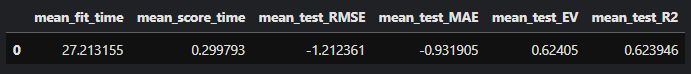

## FI

In [74]:
Xtr2, Xte2, ytr2, yte2 = train_test_split(Xte, yte, test_size = 0.3, random_state = 0)

### Evaluasi

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import explained_variance_score, r2_score

pred = grid_xgb1.predict(Xte2)

metrik = ["RMSE", "MSE", "MAE", "EV", "R2"]
model = [mean_squared_error(yte2, pred, squared = False)]

for j in [mean_squared_error, mean_absolute_error, explained_variance_score, r2_score]:
    model.append(j(yte2, pred))
    pass    

evaluasi = pd.DataFrame({"Best Model": model}, index = metrik).transpose()
evaluasi.iloc[:,3:] = evaluasi.iloc[:,3:]*100
round(evaluasi,2)

,RMSE,MSE,MAE,EV,R2
Best Model,1.19,1.41,0.92,63.87,63.86


### Permutation Importance

In [76]:
perm = permutation_importance(grid_xgb1, Xte2, yte2, n_repeats=10, random_state=0, n_jobs=-1)

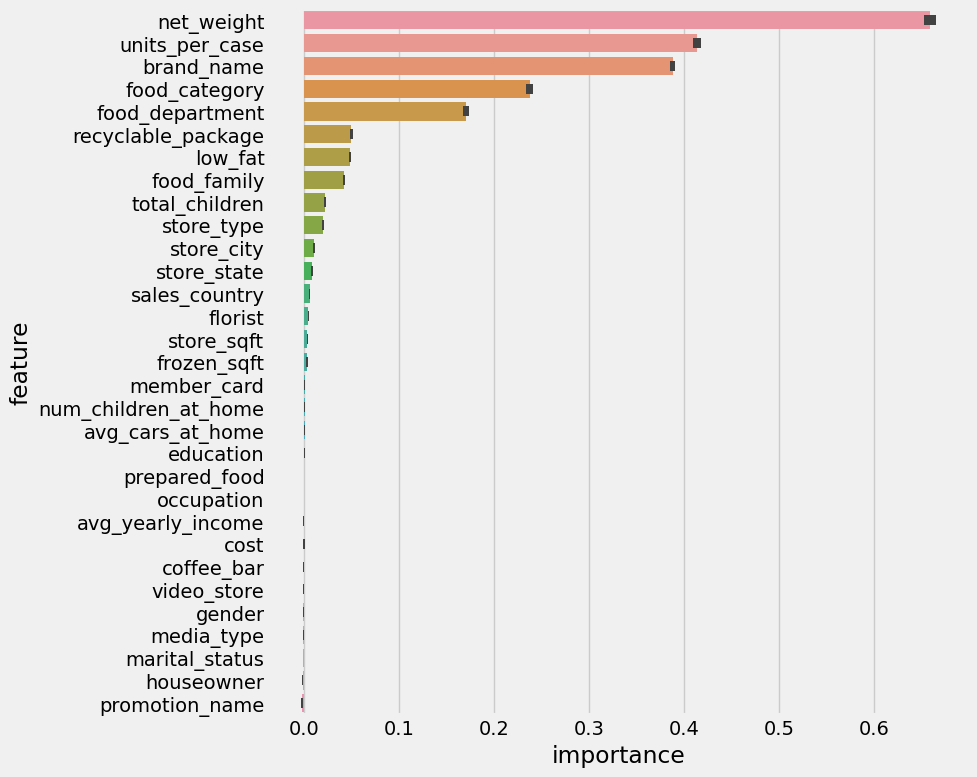

In [77]:
perm["importances_mean"]
perm2 = pd.DataFrame({'feature': Xte.columns.tolist()*10, 
                     'importance': perm["importances"].transpose().reshape(-1)})
# perm2 = perm2.sort_values('importance', ascending=False).reset_index(drop=True)
perm2["importance"] = perm2["importance"]

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=perm2, 
            order=perm2.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.tight_layout()
plt.savefig("/kaggle/working/PI")
plt.show()

# # Extra Bad
# plt.figure(figsize=(10, 8))
# sns.catplot(x='importance', y='feature', data=perm2, kind="violin",
#             order=perm2.groupby("feature").mean().sort_values("importance", ascending=False).index)

In [78]:
def moData(model, data, pre="preprocess", clf="clf"):
    pre = model.best_estimator_.named_steps[pre]
    data = pre.transform(data)
    fitur = [j.split("__")[1] for j in pre.get_feature_names_out()]
    mod = model.best_estimator_.named_steps[clf]
    dat = pd.DataFrame(data, columns=fitur)
    return mod, dat

def idShap(model, data, pre="preprocess", clf="clf", en = 1):
    mod, dat = moData(model, data)
    
    # individual
    datn = dat.iloc[(en-1):en,:]
    explainer = shap.TreeExplainer(mod, approximate=True)
    shap_values = explainer.shap_values(datn)
    return shap.force_plot(explainer.expected_value, shap_values, datn, matplotlib=True, show=False, contribution_threshold=0.05)

### Individual Shape Value

In [79]:
# for j in range(1,6):
#     idShap(grid_xgb1, Xte2, en=j)

# plt.show()
# plt.tight_layout()

## General Shap Value

In [80]:
def id_shap1(model, data, pre="preprocess", clf="clf", which="all"):
    mod, dat = moData(model, data)
    shapval = shap.TreeExplainer(mod, approximate=True).shap_values(dat)
    return shapval, dat

def pl_shap1(val, data):
#     shap.summary_plot(val, data)
    shap.summary_plot(val, data, plot_type="violin", color='coolwarm')
    plt.tight_layout()

def pl_shap2(val, data, kolom="all", R=8, K=4):
    if kolom == "all": 
        kolom = data.columns
    
    fig, axes = plt.subplots(R, K, figsize=(20,16))
    axes = axes.ravel()
    display(axes)
    
    for i, var in enumerate(kolom):
        shap.dependence_plot(var, val, data, ax=axes[i], show=False)   
    plt.tight_layout()
    
valx, datx = id_shap1(grid_xgb1, Xte2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


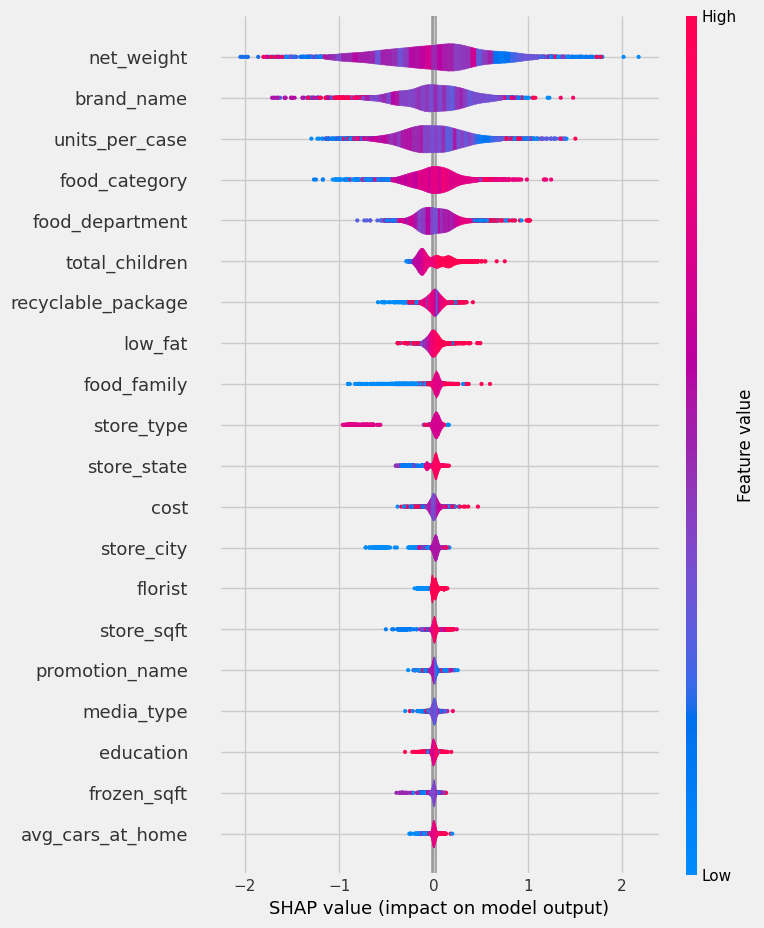

<Figure size 640x480 with 0 Axes>

In [81]:
pl_shap1(valx, datx)
plt.savefig("/kaggle/working/SS")
plt.show()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

The figure layout has changed to tight


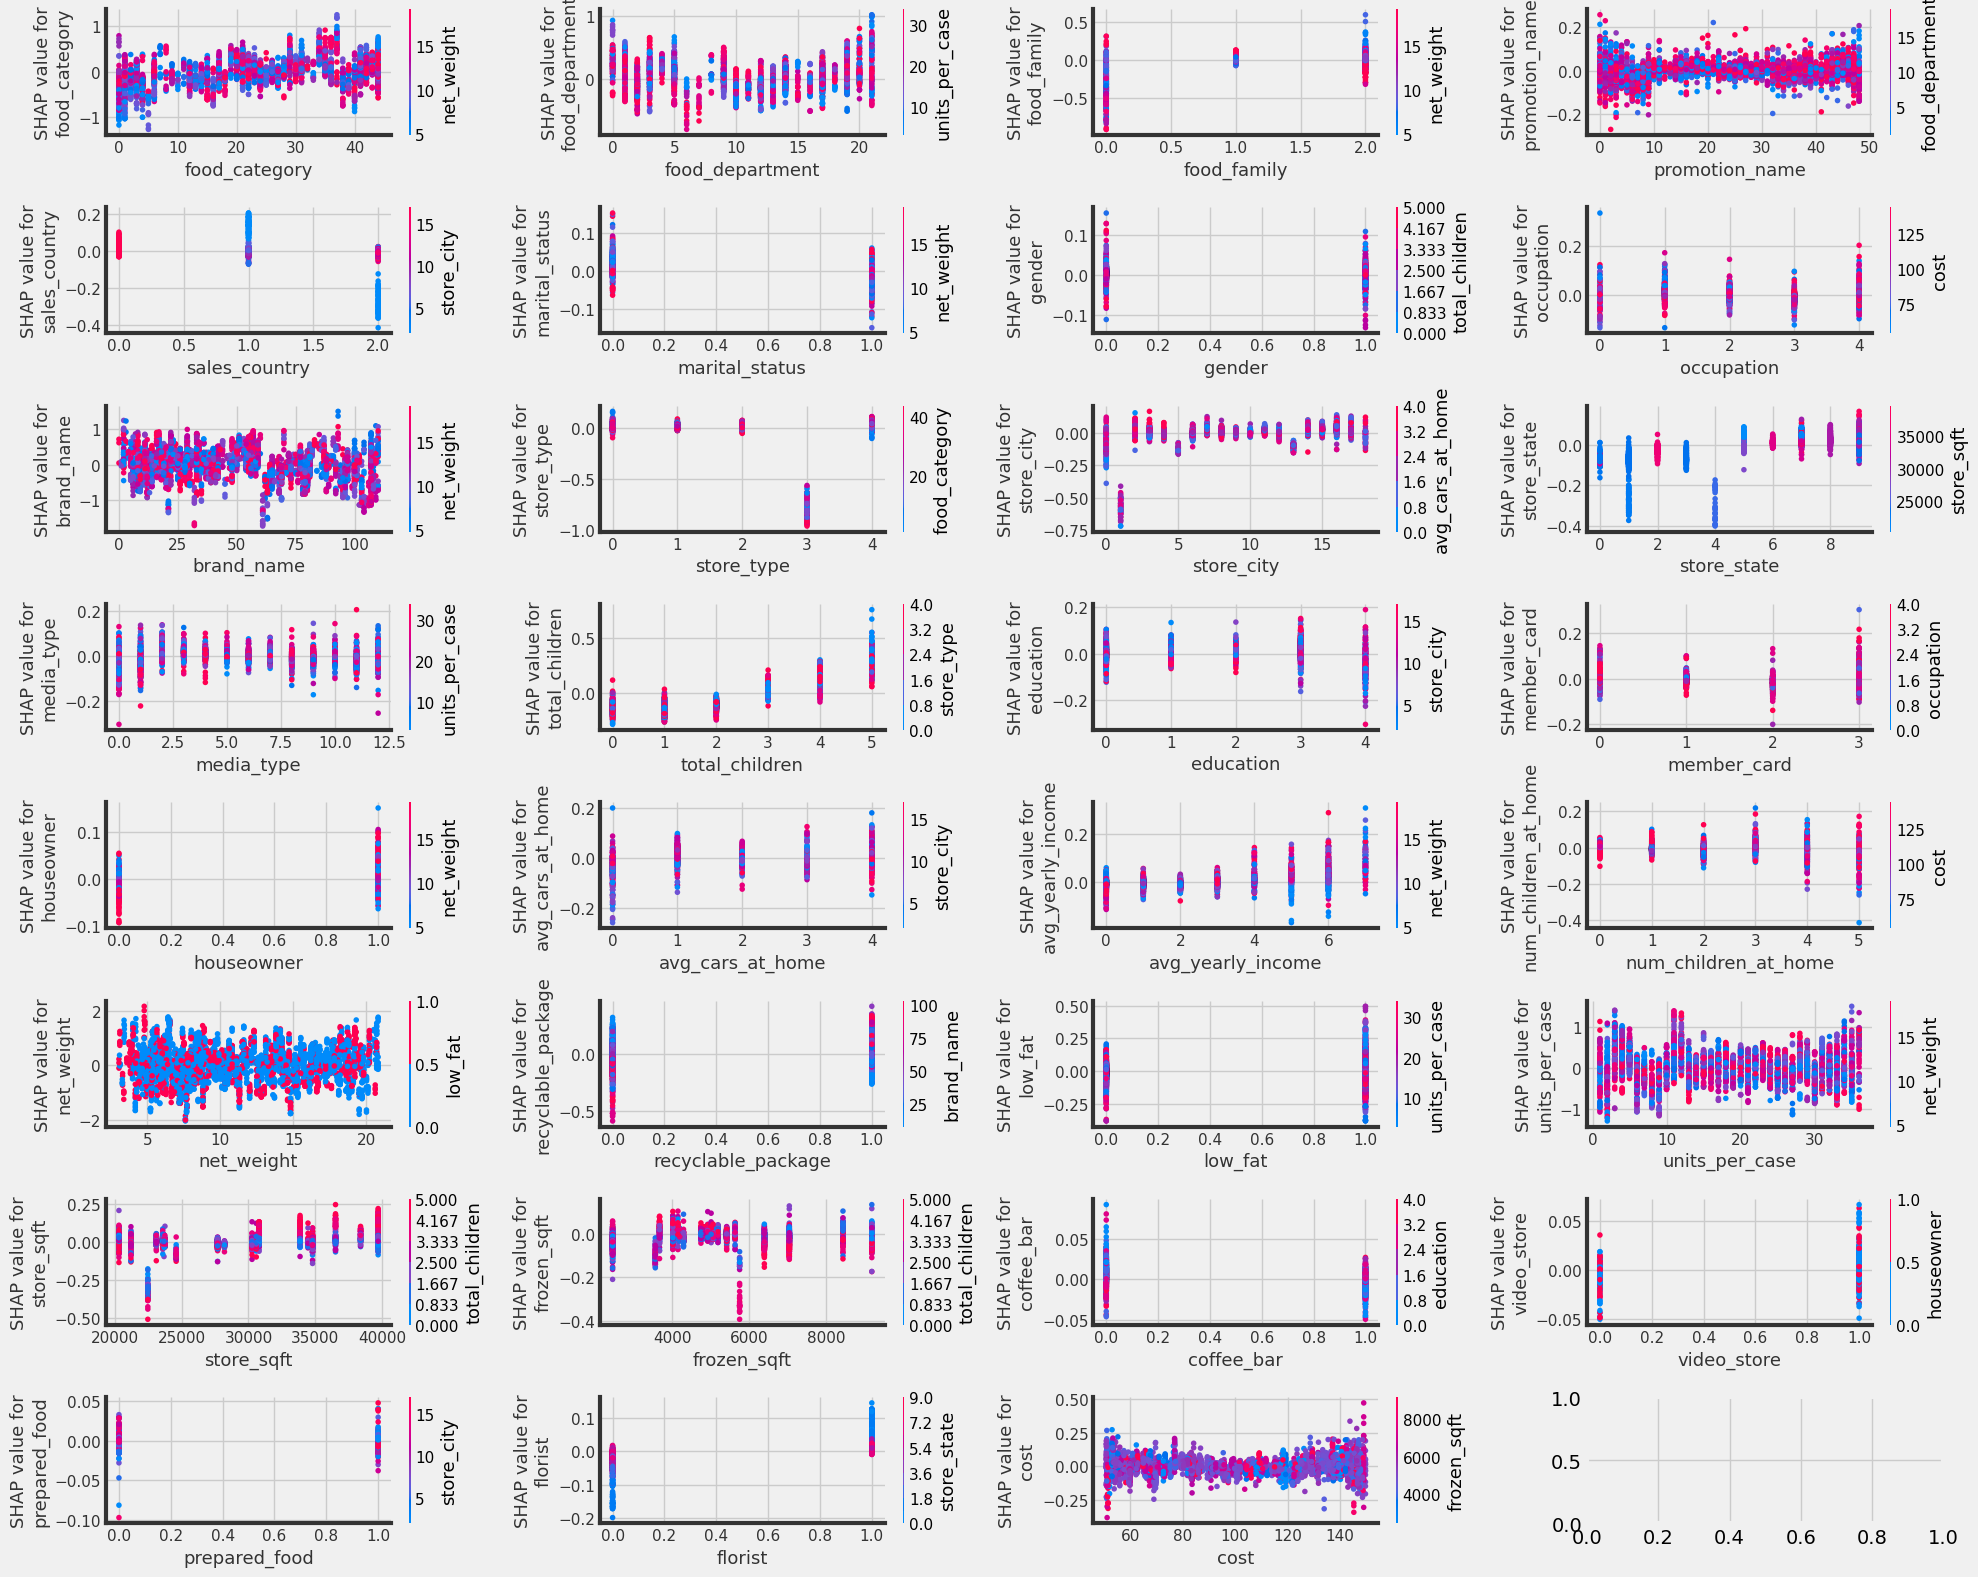

In [82]:
pl_shap2(valx, datx)
plt.tight_layout()
plt.savefig("/kaggle/working/sd")
plt.show()

In [83]:
kolshap1 = "food_family food_category net_weight recyclable_package".split(" ")
kolshap2 = "florist store_type store_sqft sales_country".split(" ")
kolshap3 = "avg_yearly_income total_children avg_cars_at_home member_card".split(" ")
kolshap = kolshap1+kolshap2+kolshap3

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

The figure layout has changed to tight


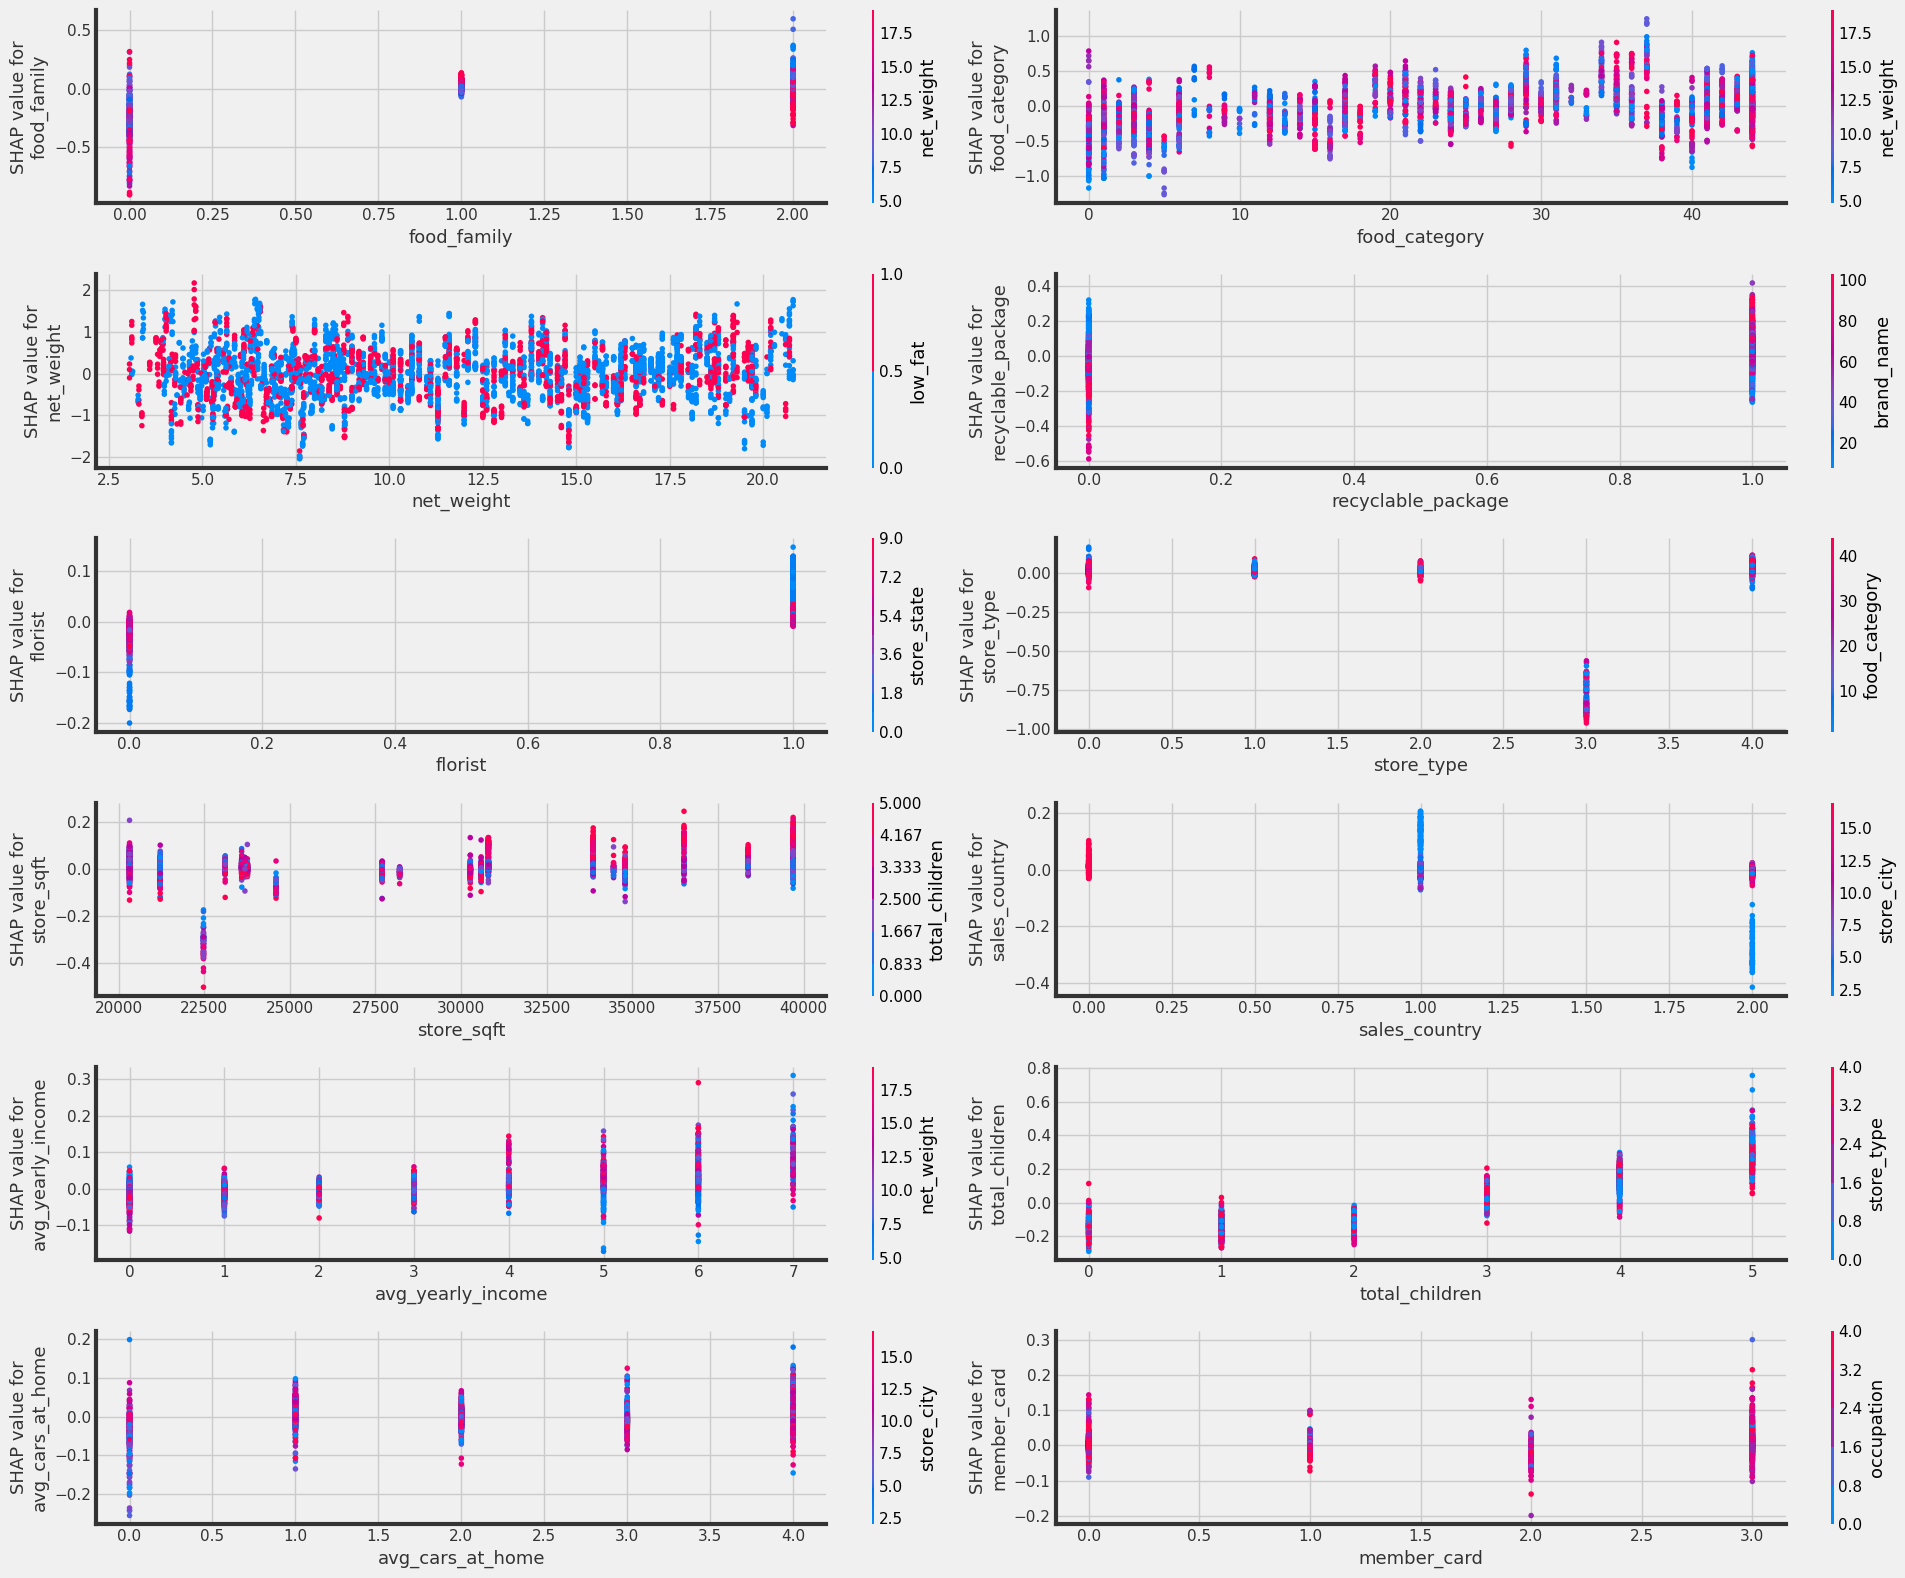

In [85]:
# zoom in. food_family, 

pl_shap2(valx, datx, kolom=kolshap, R=6, K=2)
plt.tight_layout()
plt.show()


## W/O STORE COST

In [ ]:
# X2 = Xtr.copy()
# _ = X2.pop("store_cost")
# y2 = ytr.copy()

# kat_kol2 = X2.select_dtypes("object").columns
# num_kol2 = X2.select_dtypes(exclude="object").columns

# # ordinal encoder
# kat_trf1 = Pipeline(steps=[
#     ("kat_en", OrdinalEncoder())
# ])


# num_trf1 = Pipeline(steps=[("num_im", SimpleImputer(strategy="median"))])

# # merge preprocessing
# pre_2 = ColumnTransformer(transformers=[
#     ('kat', kat_trf1, kat_kol2),
#     ('num', num_trf1, num_kol2)
# ])


In [ ]:
# res2 = pd.DataFrame()

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("pre", pre_2),
#         ("clf", model)
#     ])
    
#     grid_search = GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, 
#                                scoring={"RMSE":'neg_root_mean_squared_error',
#                                         "MAE":'neg_mean_absolute_error',
#                                         "EV":'explained_variance',
#                                         "R2":'r2'},
#                                verbose=3,
#                                refit = "RMSE")
    
#     grid_search.fit(X2, y2)
    
#     # Save the model's performance metrics in a dictionary
    
#     pdf = pd.DataFrame(grid_search.cv_results_).filter(regex=("mean_test"))
#     pdf["Model"] = type(model).__name__ 
#     pdf.set_index("Model", inplace=True)
    
#     # concat pdDF to the results list
#     res2 = pd.concat([res2, pdf])
    
# res2